# Developmental Aid Recommendation System using Unsupervised Machine Learning

### 1. Problem Statement
Development aid is given by governments and non-government agencies to support the economic, environmental, social development of developing countries.  Leaders of these agencies, needs to decide how to use their money strategically and effectively. This project will categorise countries using socio-economic and health factors to determine the overall development of the country and help the donor organizations to choose the countries based on their need of aid.

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# scaling 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# kmeans clustering 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# geo data
import geopandas as gpd
from geopandas import GeoDataFrame as gdf
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

#### Import Data

In [ ]:
data_path = '../country-data'

In [ ]:
data = pd.read_csv(
    f'{data_path}/Country-data.csv')

### 2. Exploratory Data Analysis

In [45]:
# how many columns and rows in dataframe
data.shape

(167, 10)

In [46]:
# quick view of fields and values
data.head()

country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200

In [47]:
# Columns with missing values
data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [48]:
# Describe the data statistics
data.describe()

child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    1330.000000  
50%      5.390000   73.100000    2.410000    4660.000000  
75%     10.750000   76.800000    3.880000   14050.000000  
max    104.000000   82.800000    7.490000  105000.000000

Findings: small dataset, no missing values, some outliers and skewed distribution

##### Data Distribution

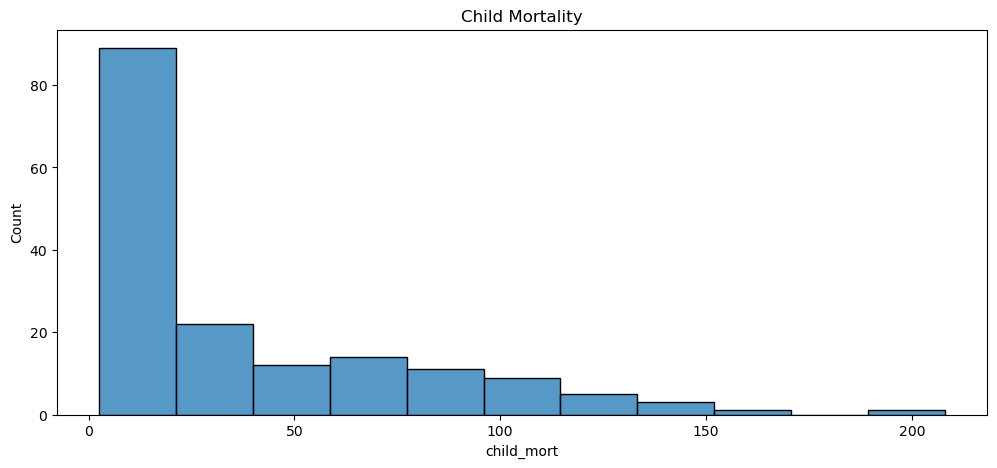

In [49]:
plt.figure(figsize=(12,5))
plt.title("Child Mortality")
ax = sns.histplot(data["child_mort"])

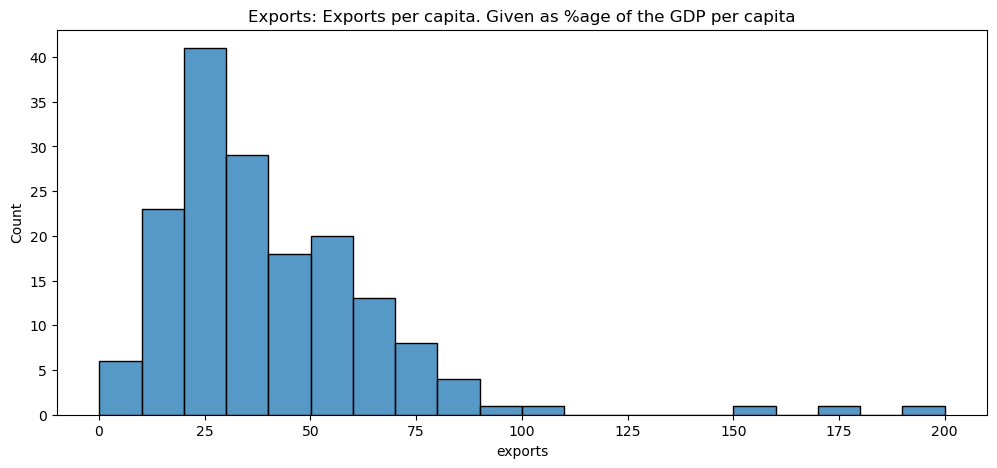

In [50]:
plt.figure(figsize=(12,5))
plt.title("Exports: Exports per capita. Given as %age of the GDP per capita")
ax = sns.histplot(data["exports"])

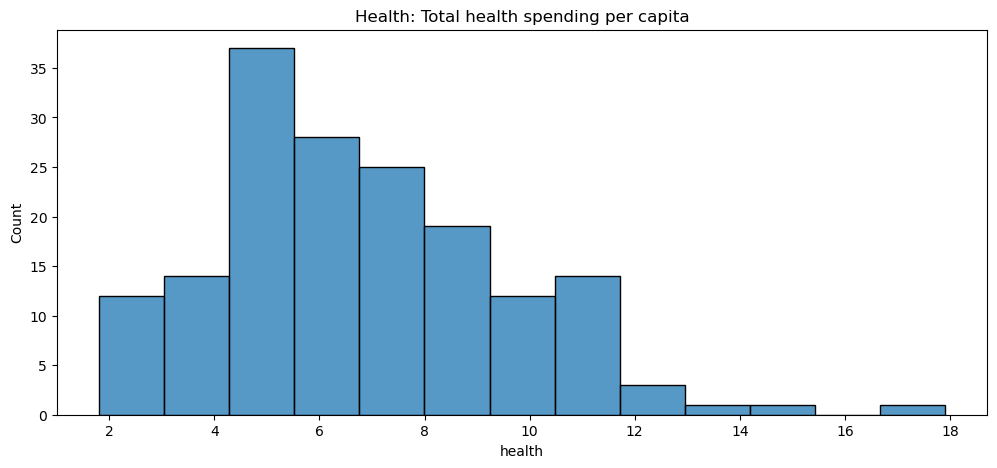

In [51]:
plt.figure(figsize=(12,5))
plt.title("Health: Total health spending per capita")
ax = sns.histplot(data["health"])


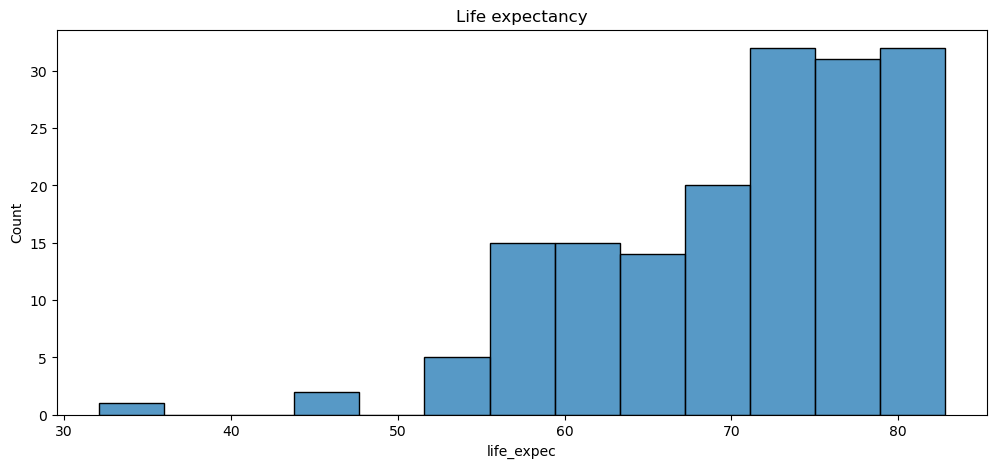

In [52]:
plt.figure(figsize=(12,5))
plt.title("Life expectancy")
ax = sns.histplot(data["life_expec"])

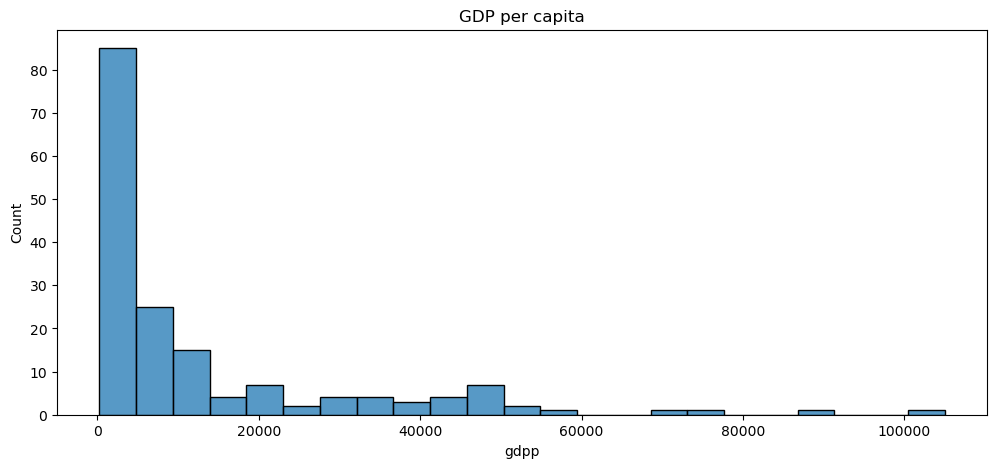

In [53]:
plt.figure(figsize=(12,5))
plt.title("GDP per capita")
ax = sns.histplot(data["gdpp"])

Findings: Looking at the data distribution we can see that some features have outliers. For the purpose of this analysis, outliers will not be removed since they could be considered very informative and point out countries that are in critical condition and in need of help.

#### Data evaluation

<Axes: >

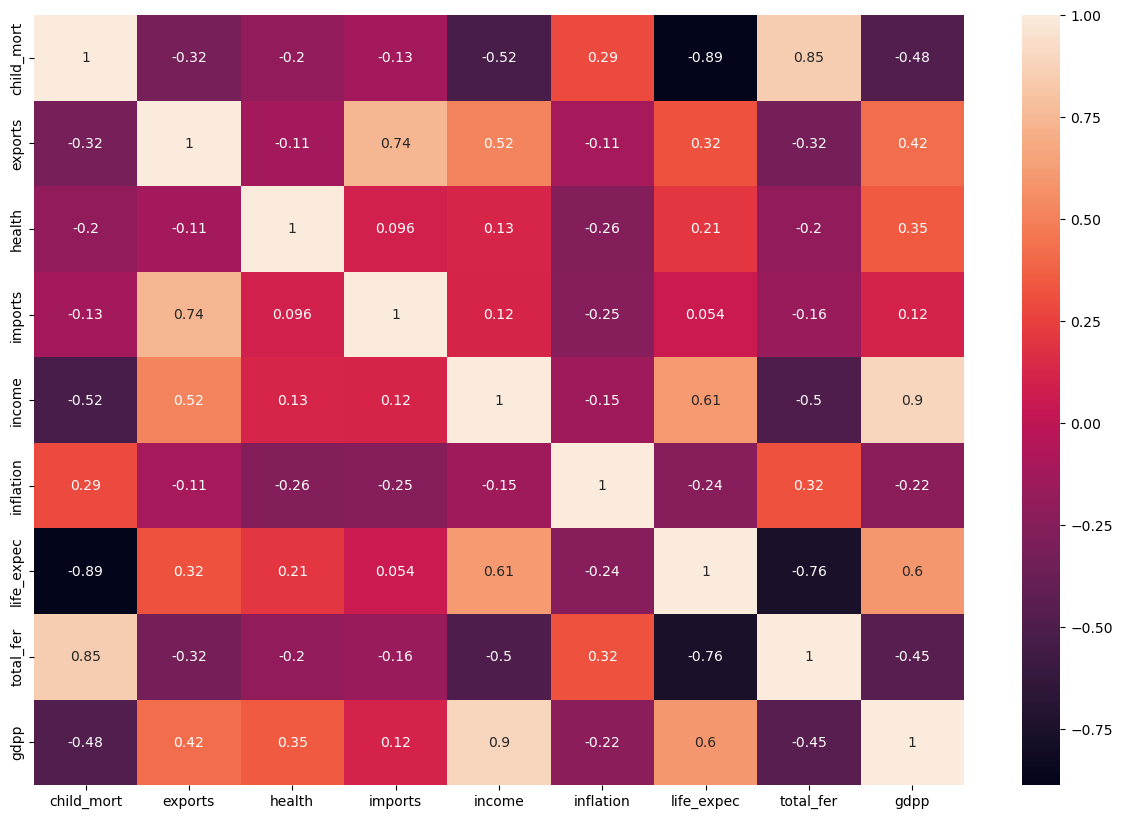

In [54]:
# correlation
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(method='pearson', min_periods=1),annot=True)

Findings: From above correlation, we can see that there are a few features that have high correlation with other features.
life_expect, due to high correlation with child mortality
total_fertility, due to high correlation with child mortality
income, due to high correlation with gdpp

#### Scaling

Some features have incomparable units, the range values of the features also vary, by scaling we are removing potential bias that the model can have towards features with higher magnitudes

In [55]:
# eliminate the column that contains the country information, as only numeric values should be used in this case for unsupervised learning
dataset = data.drop(['country'], axis =1)
dataset.head()

child_mort  exports  health  imports  income  inflation  life_expec  \
0        90.2     10.0    7.58     44.9    1610       9.44        56.2   
1        16.6     28.0    6.55     48.6    9930       4.49        76.3   
2        27.3     38.4    4.17     31.4   12900      16.10        76.5   
3       119.0     62.3    2.85     42.9    5900      22.40        60.1   
4        10.3     45.5    6.03     58.9   19100       1.44        76.8   

   total_fer   gdpp  
0       5.82    553  
1       1.65   4090  
2       2.89   4460  
3       6.16   3530  
4       2.13  12200

In [56]:
# in standardisation, all features will be transformed to have the properties of standard normal distribution with mean=0 and standard deviation=1 
columns = dataset.columns
scaler = StandardScaler()
rescaled_dataset_standard = scaler.fit_transform(dataset)
# we need to create a new dataframe with the column lables and the rescaled values 
df_standard = pd.DataFrame(data= rescaled_dataset_standard , columns = columns)
df_standard.head()

child_mort   exports    health   imports    income  inflation  life_expec  \
0    1.291532 -1.138280  0.279088 -0.082455 -0.808245   0.157336   -1.619092   
1   -0.538949 -0.479658 -0.097016  0.070837 -0.375369  -0.312347    0.647866   
2   -0.272833 -0.099122 -0.966073 -0.641762 -0.220844   0.789274    0.670423   
3    2.007808  0.775381 -1.448071 -0.165315 -0.585043   1.387054   -1.179234   
4   -0.695634  0.160668 -0.286894  0.497568  0.101732  -0.601749    0.704258   

   total_fer      gdpp  
0   1.902882 -0.679180  
1  -0.859973 -0.485623  
2  -0.038404 -0.465376  
3   2.128151 -0.516268  
4  -0.541946 -0.041817

#### Scatter Plot

Text(0, 0.5, 'Child Mortality')

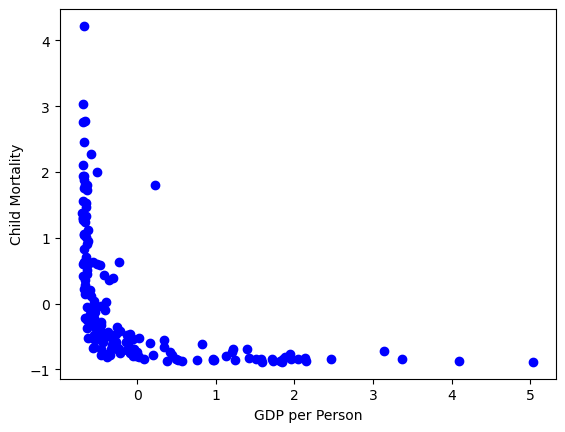

In [57]:
plt.scatter(df_standard['gdpp'], df_standard['child_mort'],color = 'blue')
plt.scatter

plt.xlabel('GDP per Person')
plt.ylabel('Child Mortality')

Text(0, 0.5, 'Child Mortality')

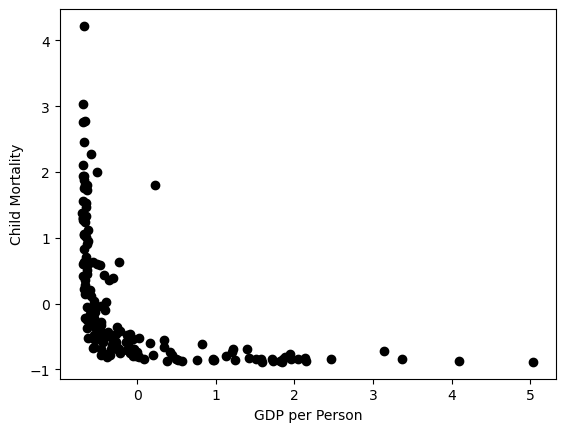

In [58]:
plt.scatter(df_standard['gdpp'], df_standard['child_mort'],color = 'black')
plt.scatter

plt.xlabel('GDP per Person')
plt.ylabel('Child Mortality')

### 3. Analysis 

#### PCA

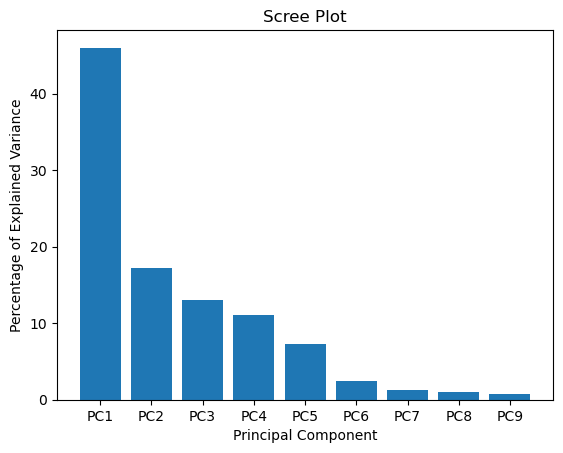

Text(0, 0.5, 'PC2 - 17.2%')

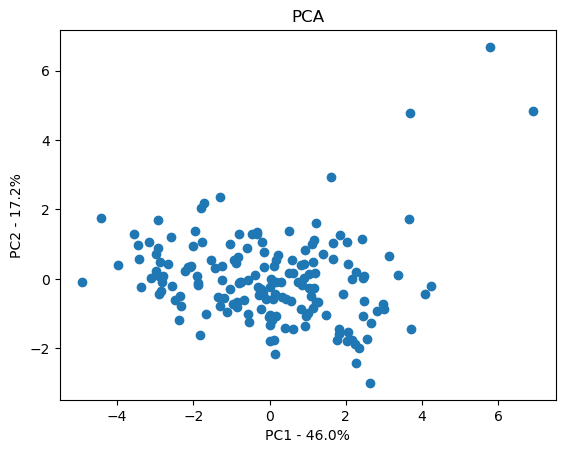

In [59]:
# import PCA 
from sklearn.decomposition import PCA

# fit and transform
pca = PCA()
pca.fit(df_standard)
pca_data_standard = pca.transform(df_standard)

# percentage variation 
per_var = np.round(pca.explained_variance_ratio_*100, decimals =1)
labels = ['PC' + str(x) for x in range (1, len(per_var)+1)]

# plot the percentage of explained variance by principal component
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

# plot pca
pca_df_standard = pd.DataFrame(pca_data_standard, columns = labels)
plt.scatter(pca_df_standard.PC1, pca_df_standard.PC2)
plt.title('PCA')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

In [60]:
# dataframe with PC1, PC2, P3, PC4
data2 = pca_df_standard.drop(['PC5','PC6','PC7','PC8','PC9'], axis = 1)
data2.head()

PC1       PC2       PC3       PC4
0 -2.913025  0.095621 -0.718118  1.005255
1  0.429911 -0.588156 -0.333486 -1.161059
2 -0.285225 -0.455174  1.221505 -0.868115
3 -2.932423  1.695555  1.525044  0.839625
4  1.033576  0.136659 -0.225721 -0.847063

Findings: 
After doing PCA of the original dataset, we see that 4 principal components explain about 90% of the distribution of the original data.

#### 4. Model - K-Means Clustering

In [61]:
km = KMeans (
    n_clusters = 3, 
    init = 'random', 
    n_init = 10, 
    max_iter = 300, 
    tol = 1e-4, 
    random_state = 0 
)

In [62]:
# method to compute the clusters and assign the labels
y_predicted_standard = km.fit_predict(df_standard) 
y_predicted_standard

array([1, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1,
       0, 2, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 2, 2,
       2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 1, 0, 2, 1, 2, 0, 0, 1, 1, 0,
       1, 0, 2, 0, 0, 0, 1, 2, 2, 2, 0, 2, 0, 0, 1, 1, 2, 0, 1, 0, 0, 1,
       1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       2, 2, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 2, 2, 2, 0, 1, 2, 2, 0, 0, 1, 0, 2, 2, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1])

In [63]:
# data2 is the dataset with 4 principal components found with PCA
# method to compute the clusters and assign the labels
y_predicted_data2 = km.fit_predict(data2) 
y_predicted_data2

array([1, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1,
       0, 2, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 2, 2,
       2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 1, 0, 2, 1, 2, 0, 0, 1, 1, 0,
       1, 0, 2, 0, 0, 0, 1, 2, 2, 2, 0, 2, 0, 0, 1, 1, 2, 0, 1, 0, 0, 1,
       1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       2, 2, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 2, 2, 2, 1, 1, 2, 2, 0, 0, 1, 0, 2, 2, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1])

In [64]:
# add the cluster column to the standard dataframe 
df_standard['cluster'] = y_predicted_standard
df_standard.head()

child_mort   exports    health   imports    income  inflation  life_expec  \
0    1.291532 -1.138280  0.279088 -0.082455 -0.808245   0.157336   -1.619092   
1   -0.538949 -0.479658 -0.097016  0.070837 -0.375369  -0.312347    0.647866   
2   -0.272833 -0.099122 -0.966073 -0.641762 -0.220844   0.789274    0.670423   
3    2.007808  0.775381 -1.448071 -0.165315 -0.585043   1.387054   -1.179234   
4   -0.695634  0.160668 -0.286894  0.497568  0.101732  -0.601749    0.704258   

   total_fer      gdpp  cluster  
0   1.902882 -0.679180        1  
1  -0.859973 -0.485623        0  
2  -0.038404 -0.465376        0  
3   2.128151 -0.516268        1  
4  -0.541946 -0.041817        0

In [65]:
# add the cluster column to the dataset 
dataset['cluster'] = y_predicted_data2
dataset.head()

child_mort  exports  health  imports  income  inflation  life_expec  \
0        90.2     10.0    7.58     44.9    1610       9.44        56.2   
1        16.6     28.0    6.55     48.6    9930       4.49        76.3   
2        27.3     38.4    4.17     31.4   12900      16.10        76.5   
3       119.0     62.3    2.85     42.9    5900      22.40        60.1   
4        10.3     45.5    6.03     58.9   19100       1.44        76.8   

   total_fer   gdpp  cluster  
0       5.82    553        1  
1       1.65   4090        0  
2       2.89   4460        0  
3       6.16   3530        1  
4       2.13  12200        0

#### Optimal number of clusters: Elbow Method

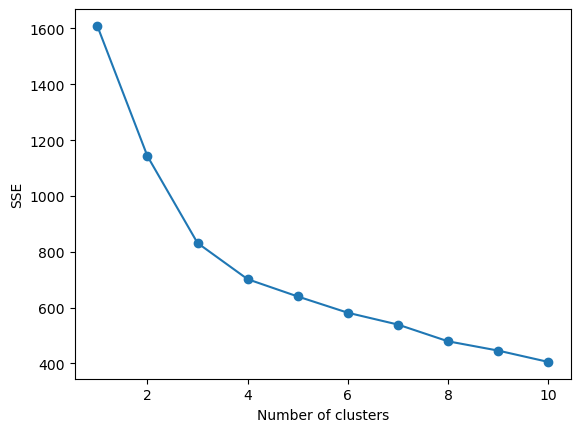

In [66]:
# calculate Sum of Squared Errors (SSE)

sse = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df_standard)
    sse.append(km.inertia_)

# plot
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()


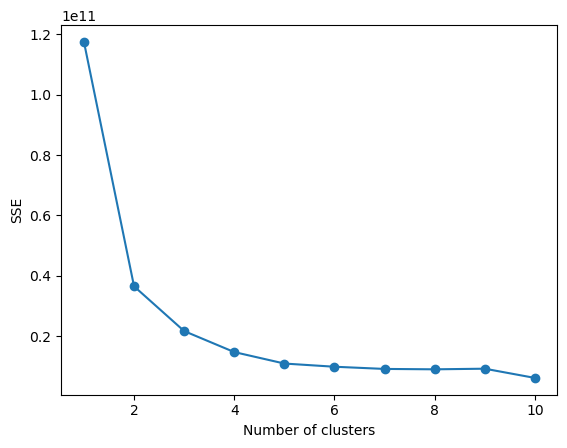

In [67]:
# calculate Sum of Squared Errors (SSE), also called distorsions, for a range of number of cluster - with df scaled with StandardScaler + PCA
sse = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(dataset)
    sse.append(km.inertia_)

# plot
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

Findings

After running the K-Means model with  a standardised dataset and a PCA with 4 components (with standardised scaling) we can see that the optimal number of clusters is still 3 with different levels of inertia. Two clusters could also be considered as per results of dataset after PCA.

In [68]:
# calculate Silhoutte Score - stardardised
score = silhouette_score(df_standard, km.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.017


In [69]:
# Calculate Silhoutte Score - stardardised + PCA
score = silhouette_score(dataset, km.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.489


Findings

Silhouette Scores are very close to 0 indicating that clusters are overlapping. An increase in clusters shows that there are negative values in the scale, meaning that this n of clusters might have samples that have been assigned to the wrong cluster.

#### Cluster analysis

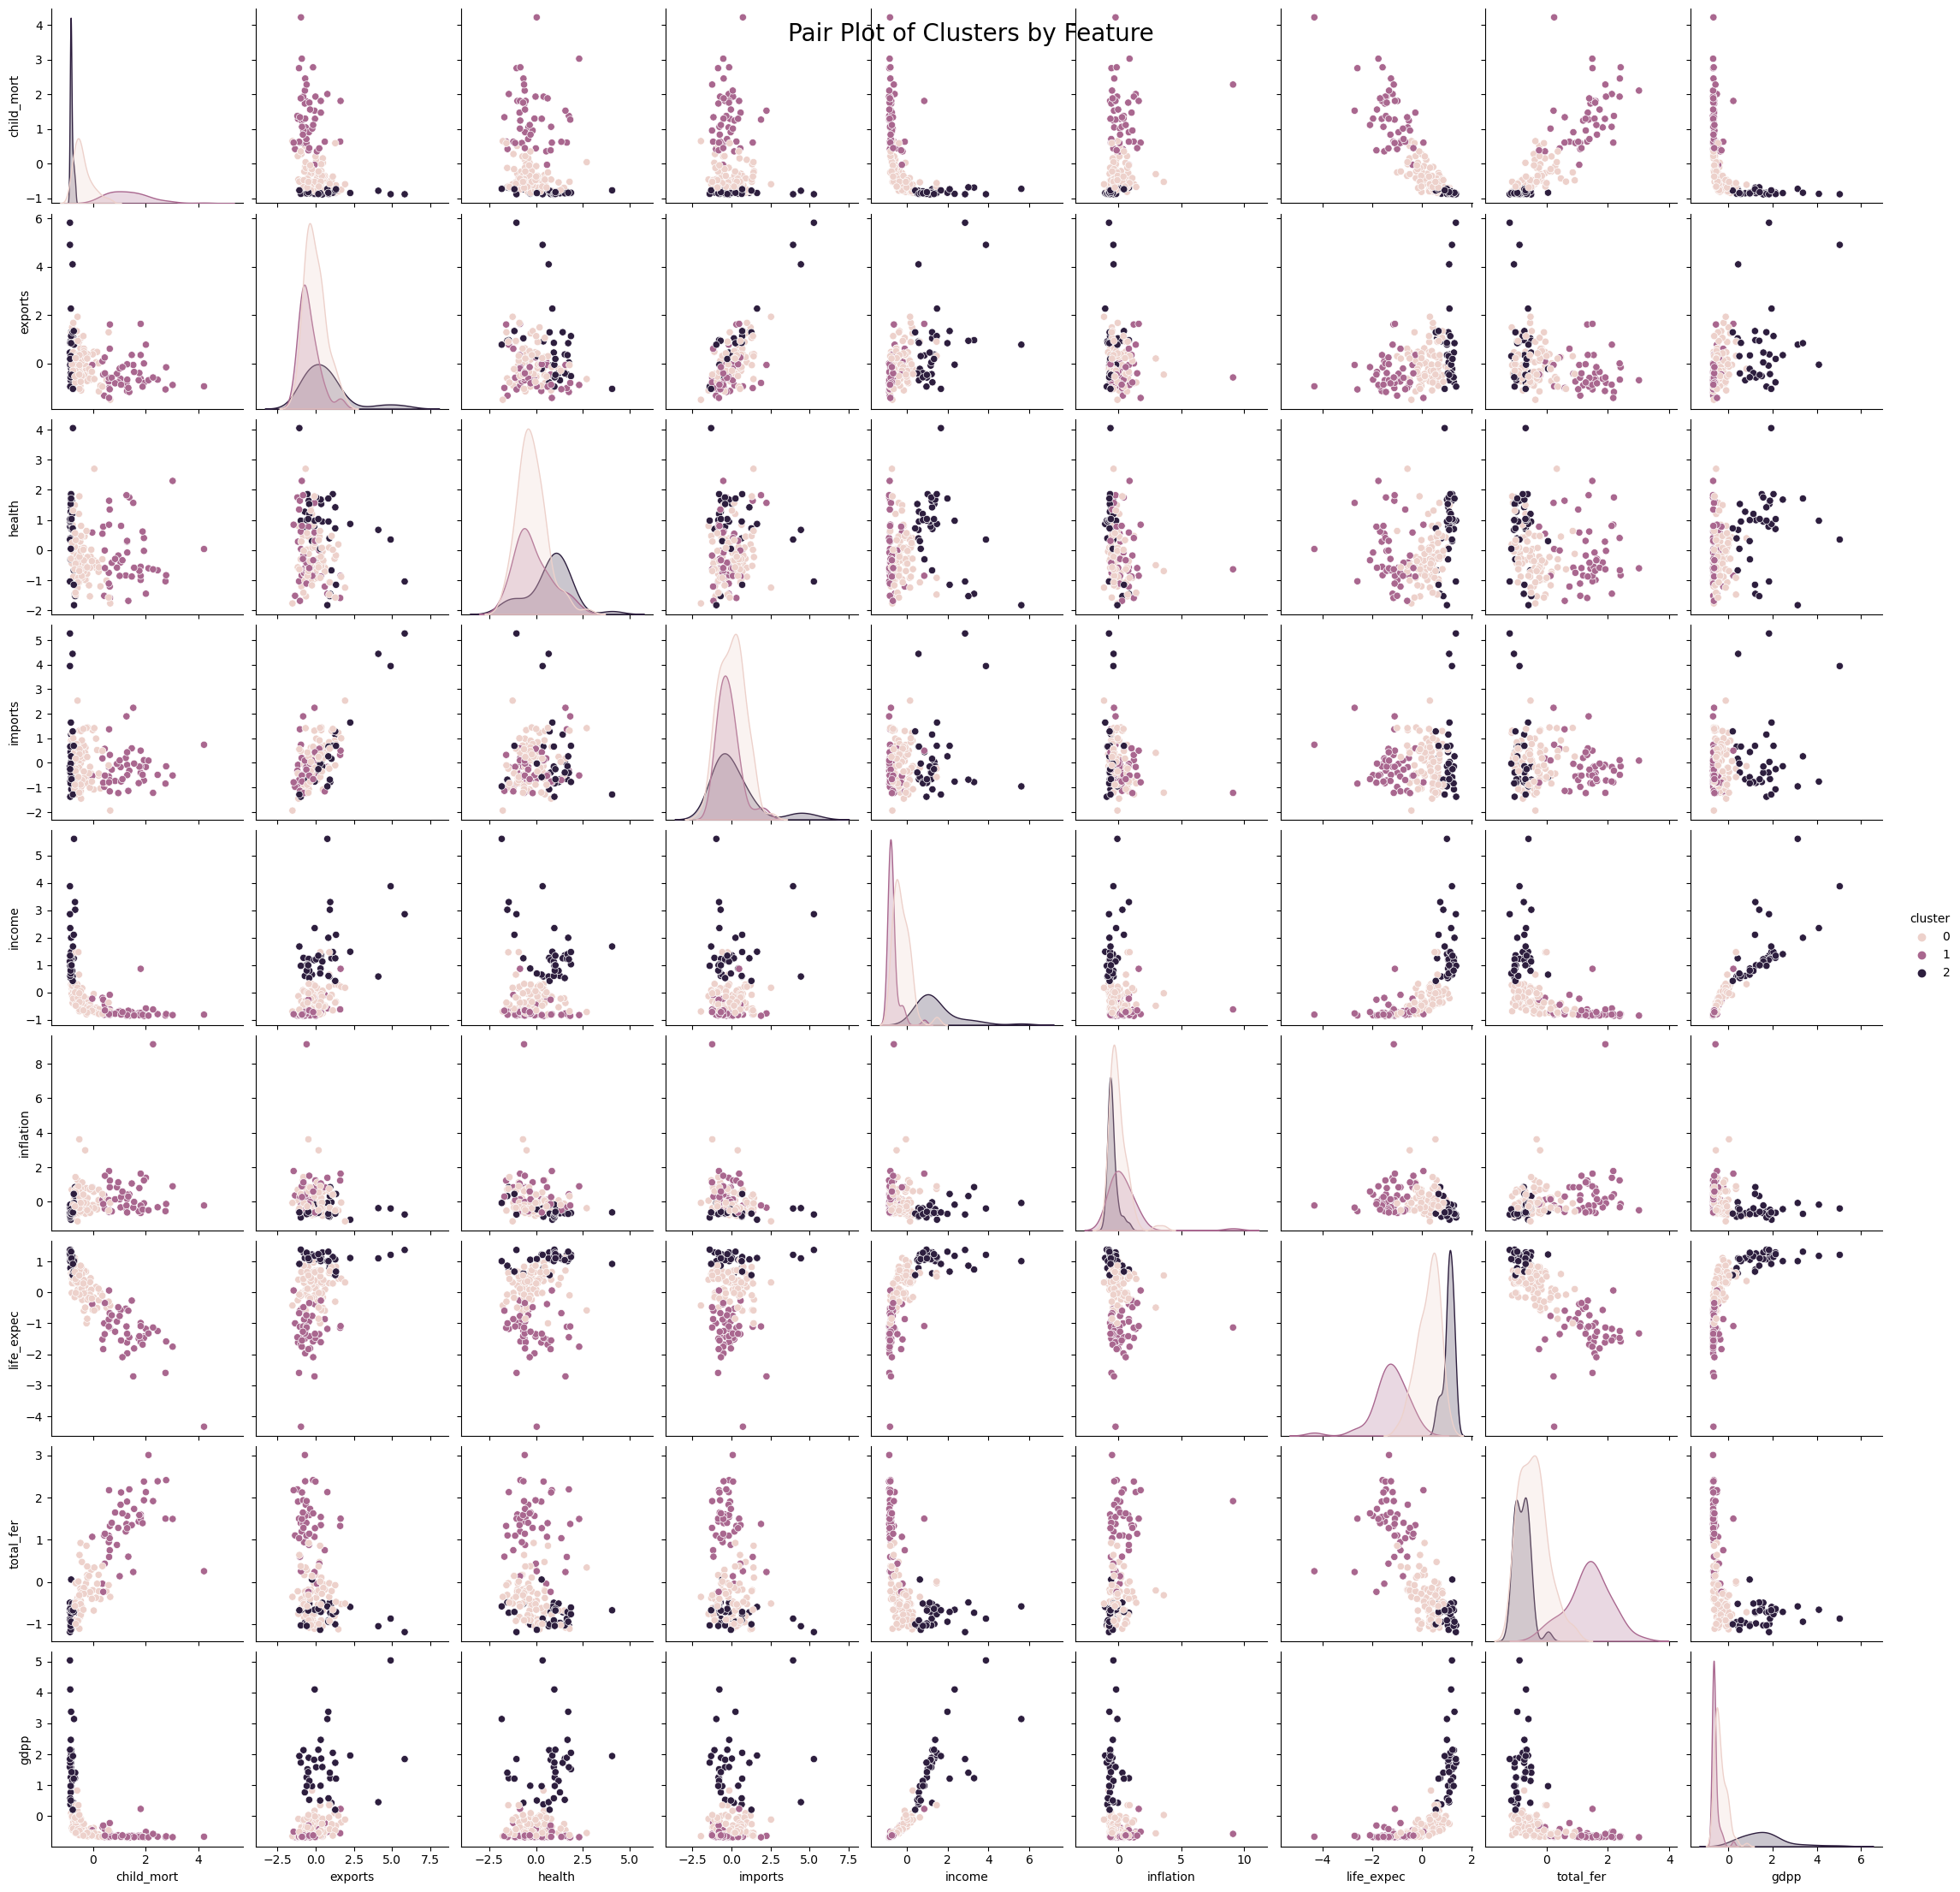

In [70]:
# load example dataset from seaborn 
sns.get_dataset_names()
# plot
sns.pairplot(df_standard, hue="cluster")
# title
plt.suptitle('Pair Plot of Clusters by Feature', 
             size = 20);

Visualise clusters by feature, scaled data with StandardScaler and with reduction of features with PCA

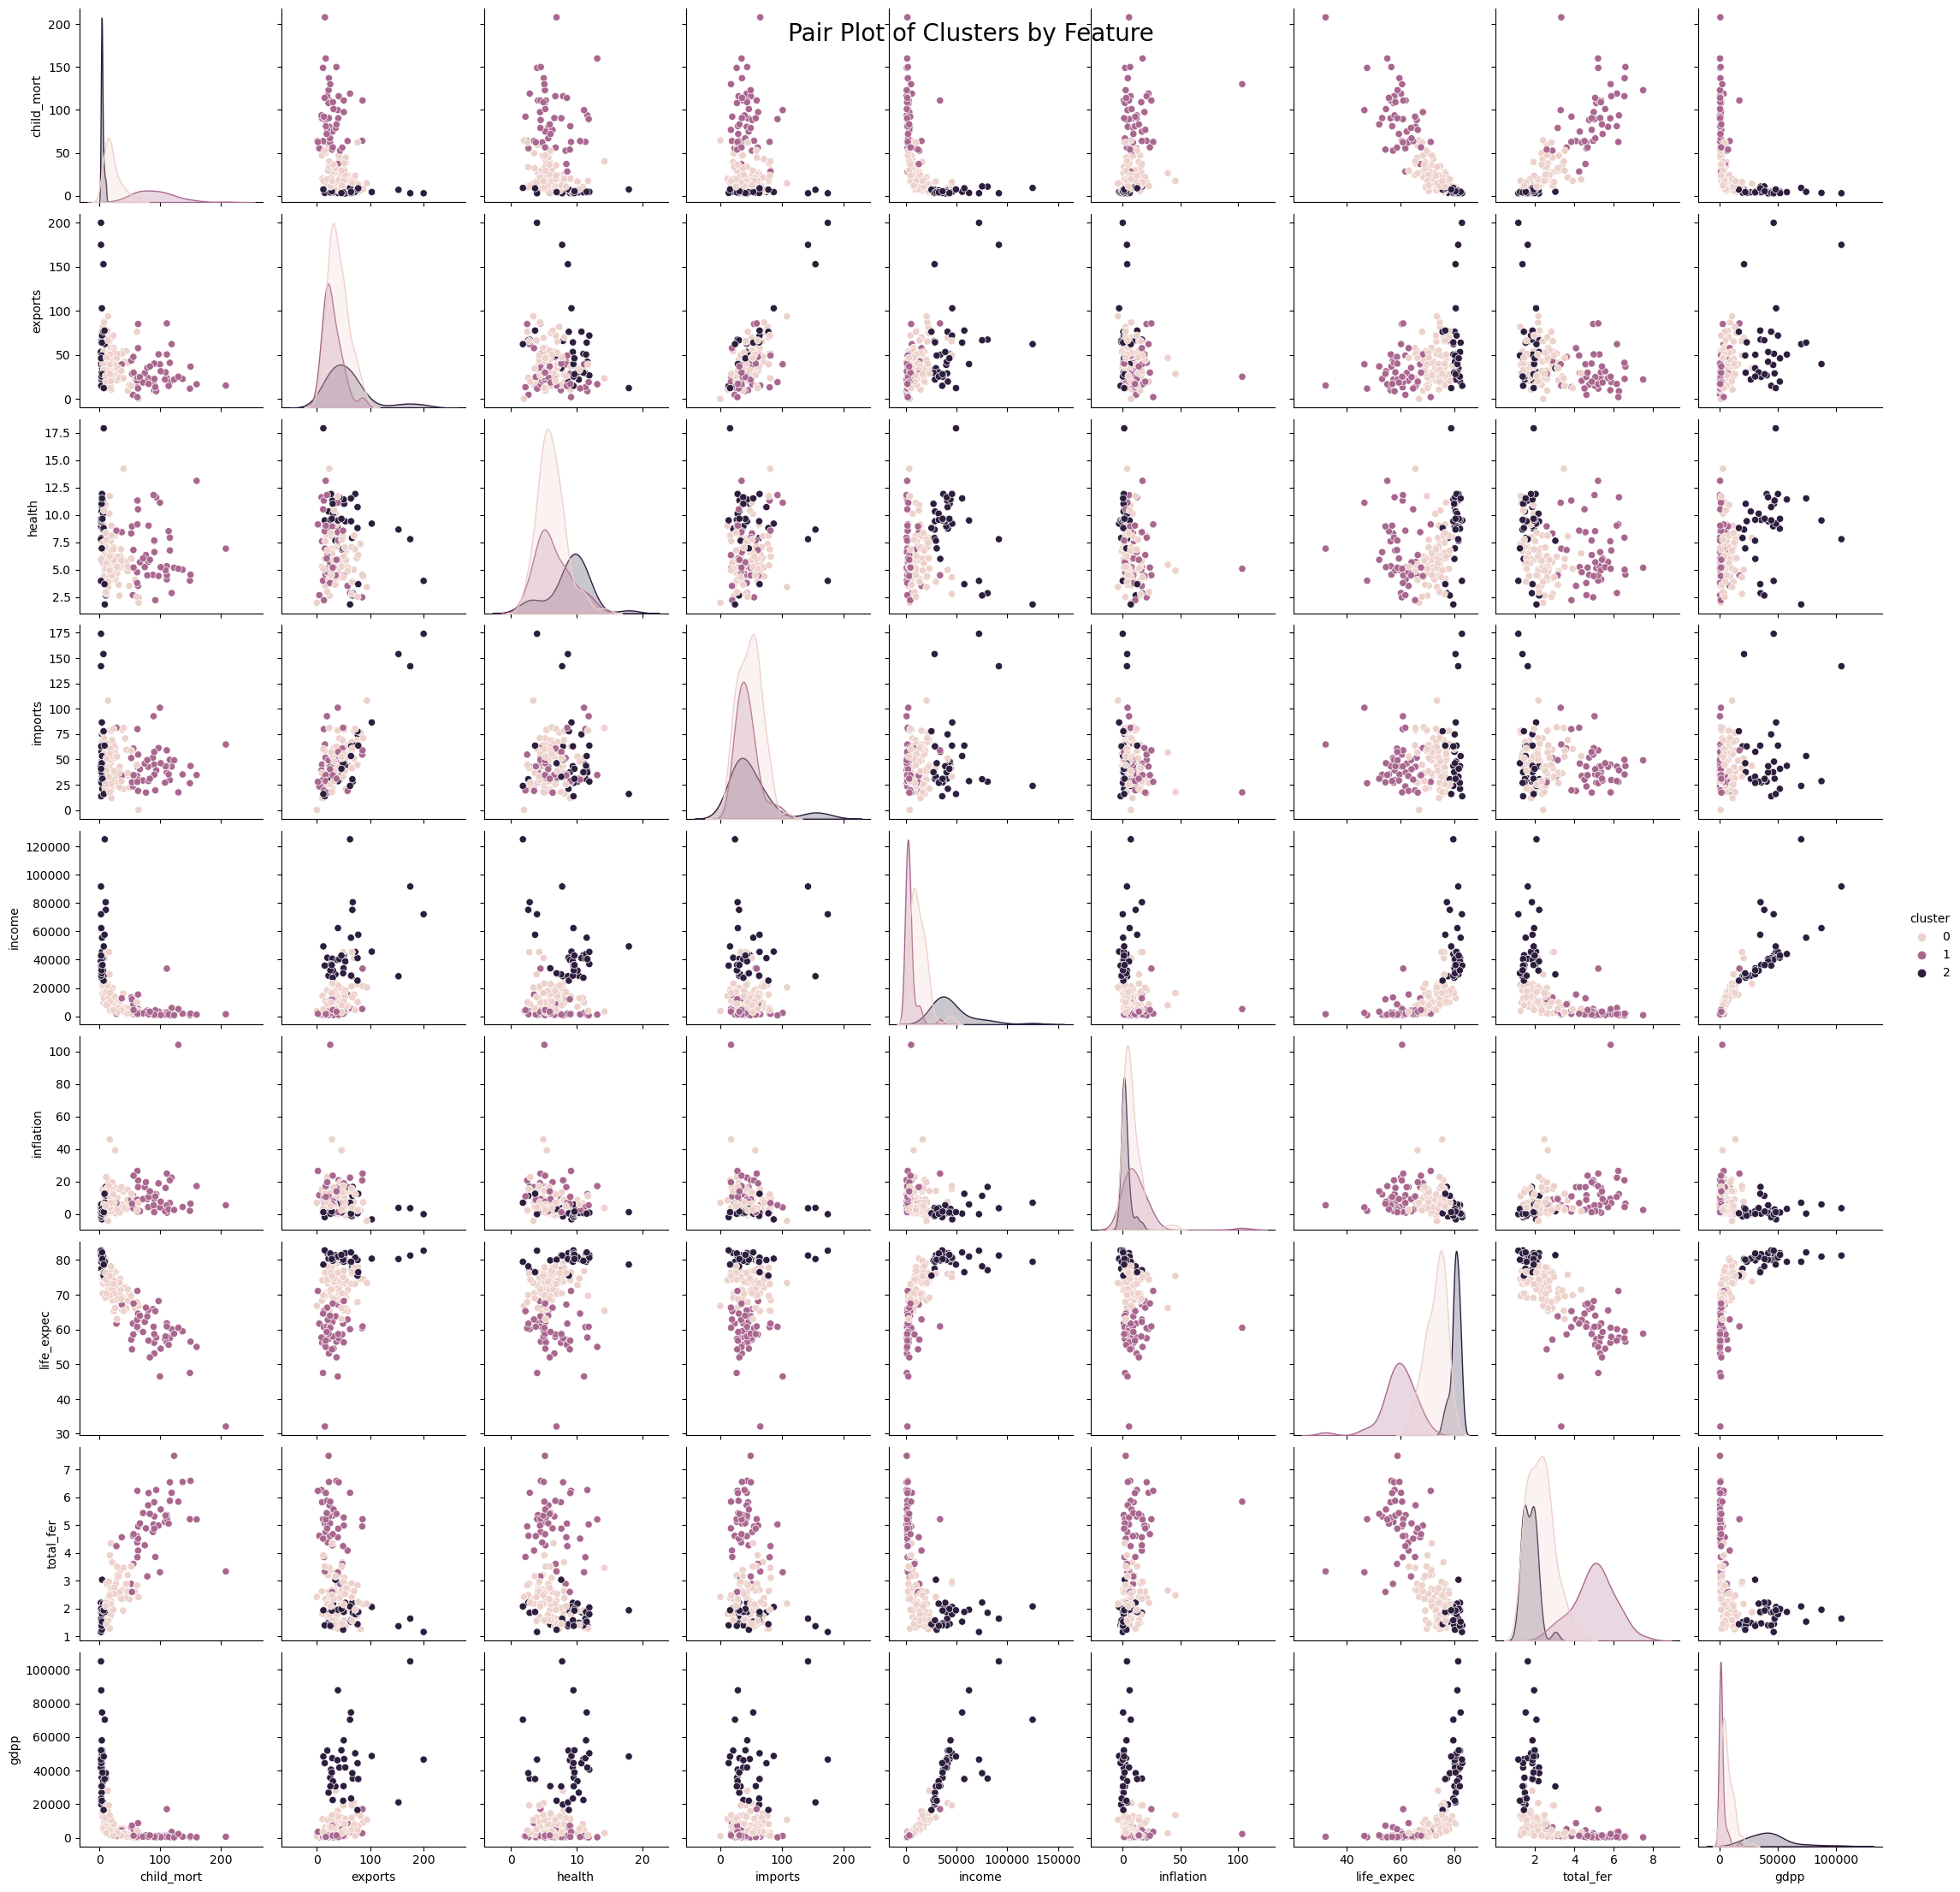

In [43]:
# load example dataset from seaborn 
sns.get_dataset_names()
# plot
sns.pairplot(dataset, hue="cluster")
# title
plt.suptitle('Pair Plot of Clusters by Feature', 
             size = 20);

Findings

After running the model with 2 types of scaling and using PCA, we can see there tends to be overlapping between clusters. Cluster 2 is more spread out and clusters 0 and 1 tend to overlap.

In [71]:
# add cluster column to original dataset with countries and non-scaled values
data['cluster'] = y_predicted_standard.tolist()
data.head()

country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  cluster  
0       9.44        56.2       5.82    553        1  
1       4.49        76.3       1.65   4090        0  
2      16.10        76.5       2.89   4460        0  
3      22.40        60.1       6.16   3530        1  
4       1.44        76.8       2.13  12200        0

In [72]:
# table of clusters showing mean values per cluster and per feature
clusters_table = pd.pivot_table(data, index=['cluster'])
clusters_table

child_mort    exports          gdpp    health    imports  \
cluster                                                             
0         21.927381  40.243917   6486.452381  6.200952  47.473404   
1         92.961702  29.151277   1922.382979  6.388511  42.323404   
2          5.000000  58.738889  42494.444444  8.807778  51.491667   

               income  inflation  life_expec  total_fer  
cluster                                                  
0        12305.595238   7.600905   72.814286   2.307500  
1         3942.404255  12.019681   59.187234   5.008085  
2        45672.222222   2.671250   80.127778   1.752778

In [73]:
# cluster 0 
cluster_0 = data.loc[data['cluster'] == 0]
# list of countries in this country
cluster_0.country.unique()

array(['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Azerbaijan', 'Bahamas', 'Bangladesh', 'Barbados',
       'Belarus', 'Belize', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Brazil', 'Bulgaria', 'Cambodia', 'Cape Verde', 'Chile', 'China',
       'Colombia', 'Costa Rica', 'Croatia', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Fiji', 'Georgia',
       'Grenada', 'Guatemala', 'Guyana', 'Hungary', 'India', 'Indonesia',
       'Iran', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kyrgyz Republic',
       'Latvia', 'Lebanon', 'Libya', 'Lithuania', 'Macedonia, FYR',
       'Malaysia', 'Maldives', 'Mauritius', 'Micronesia, Fed. Sts.',
       'Moldova', 'Mongolia', 'Montenegro', 'Morocco', 'Myanmar', 'Nepal',
       'Oman', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland',
       'Romania', 'Russia', 'Samoa', 'Saudi Arabia', 'Serbia',
       'Seychelles', 'Solomon Islands', 'Sri Lanka',
       'St. Vincent and the Grenadines'

Cluster 0: This cluster is characterised by showing average values for all features when comparing with other clusters

child mortality, avg
exports, avg
gdpp, avg
health, same as cluster 1
imports, avg
income, avg
inflation, avg
life_expect, +70 years
total_fer, avg, 2 children per woman (number of children that would be born to each woman if the current age-fertility rates remain the same)

In [74]:
# cluster 1 
cluster_1 = data.loc[data['cluster'] == 1]

# list of countries in this country
cluster_1.country.unique()

array(['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cameroon', 'Central African Republic', 'Chad',
       'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire",
       'Equatorial Guinea', 'Eritrea', 'Gabon', 'Gambia', 'Ghana',
       'Guinea', 'Guinea-Bissau', 'Haiti', 'Iraq', 'Kenya', 'Kiribati',
       'Lao', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali',
       'Mauritania', 'Mozambique', 'Namibia', 'Niger', 'Nigeria',
       'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone', 'South Africa',
       'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Yemen',
       'Zambia'], dtype=object)

Cluster 1: This cluster is characterised by having the most negative values: high child mortality, lowest economic development, low gdpp, exports and imports, lowest life expectancy

In [75]:
# cluster 2 
cluster_2 = data.loc[data['cluster'] == 2]
cluster_2.country.unique()

array(['Australia', 'Austria', 'Bahrain', 'Belgium', 'Brunei', 'Canada',
       'Cyprus', 'Czech Republic', 'Denmark', 'Finland', 'France',
       'Germany', 'Greece', 'Iceland', 'Ireland', 'Israel', 'Italy',
       'Japan', 'Kuwait', 'Luxembourg', 'Malta', 'Netherlands',
       'New Zealand', 'Norway', 'Portugal', 'Qatar', 'Singapore',
       'Slovak Republic', 'Slovenia', 'South Korea', 'Spain', 'Sweden',
       'Switzerland', 'United Arab Emirates', 'United Kingdom',
       'United States'], dtype=object)

Cluster 2: This cluster is characterised by showing really strong or positive values such as good economic development, high life expectancy, low child mortality

#### Further analysis of clusters

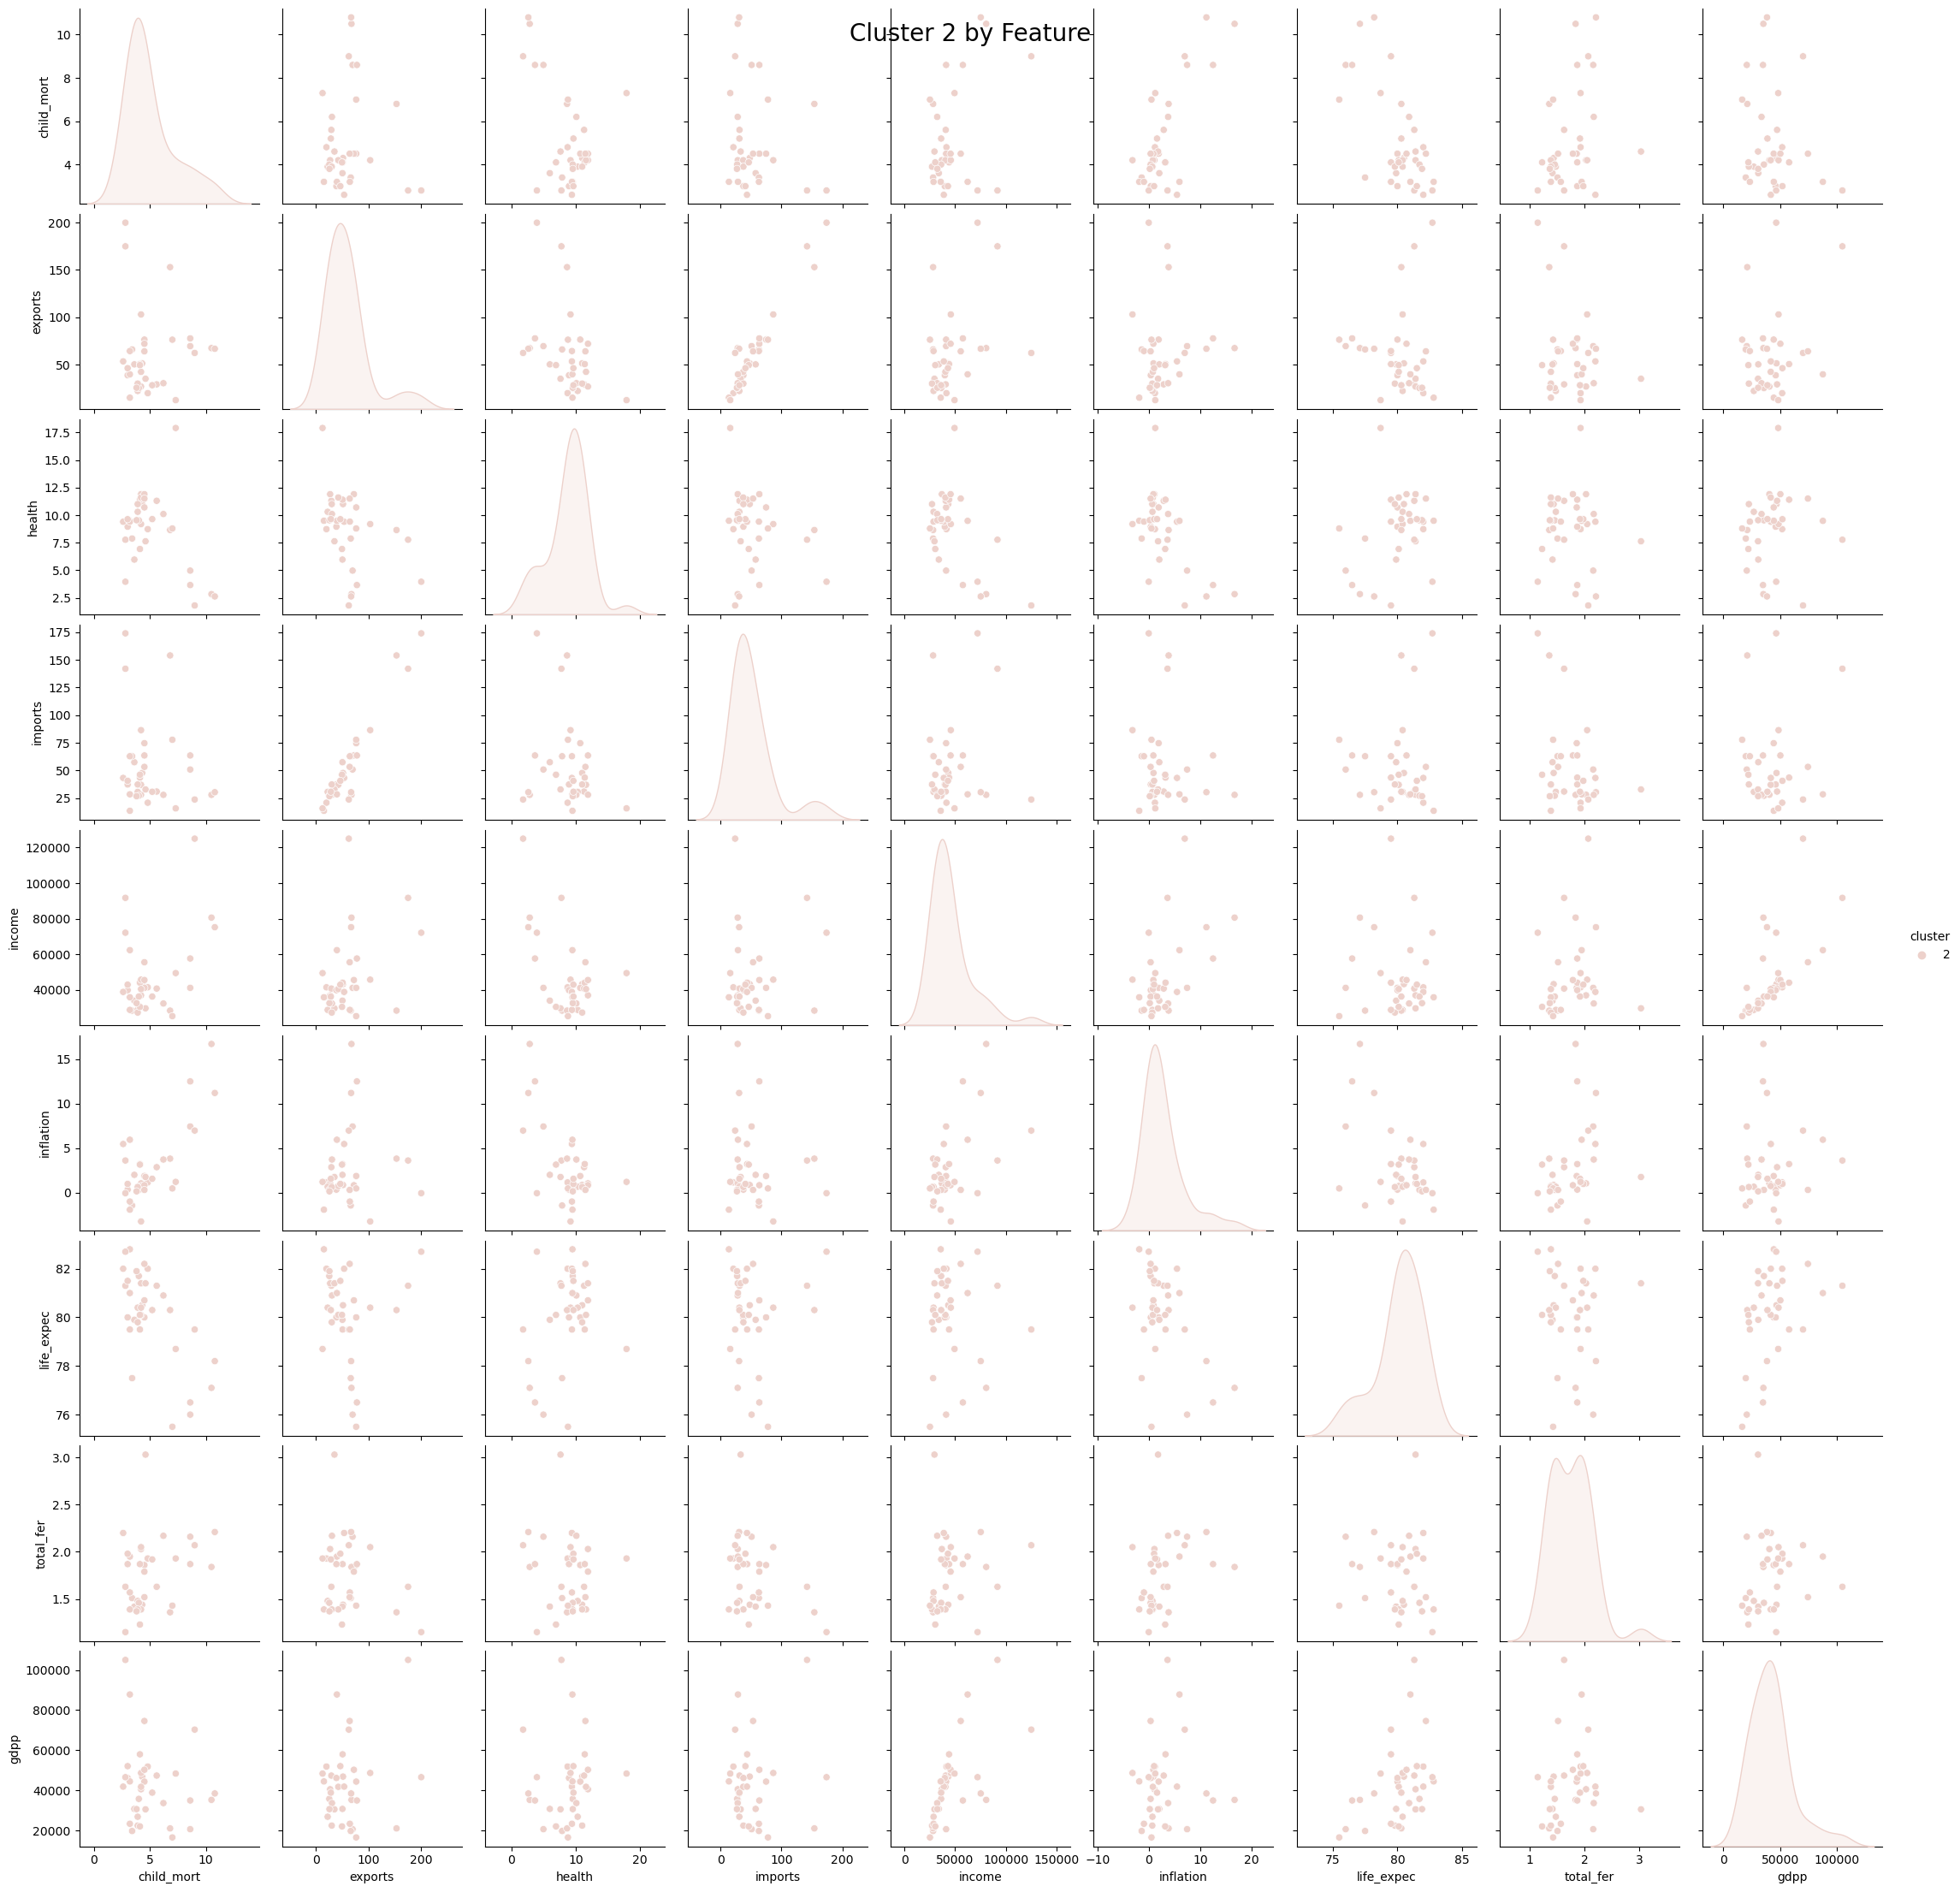

In [76]:
# df cluster 2 
df3 = data[data.cluster == 2]

# load example dataset from seaborn 
sns.get_dataset_names()

# plot
sns.pairplot(df3, hue='cluster')

# title
plt.suptitle('Cluster 2 by Feature', 
             size = 20);

Findings:
Outliers found in features in this cluster are generally more positive and distant from values from clusters 0 and 1. Countries in this cluster are not going to be considered for funding.

There are about 2 or 3 clusters with high levels of overlapping, therefore we need to do further analysis that can help us answer the question at hand with more supporting evidence.

For this we'll incorporate a new feature called Multidimensional Poverty Index (MPI) from the Multidimensional Poverty Measures dataset.

In [77]:
# import data
mpi_data = pd.read_csv(
    f'{data_path}/MPI_national.csv')
mpi_data.head()

ISO     Country  MPI Urban  Headcount Ratio Urban  \
0  KAZ  Kazakhstan      0.000                    0.0   
1  SRB      Serbia      0.000                    0.1   
2  KGZ  Kyrgyzstan      0.000                    0.1   
3  TUN     Tunisia      0.000                    0.1   
4  ARM     Armenia      0.001                    0.2   

   Intensity of Deprivation Urban  MPI Rural  Headcount Ratio Rural  \
0                            33.3      0.000                   0.09   
1                            41.4      0.002                   0.50   
2                            40.2      0.003                   0.70   
3                            35.6      0.012                   3.18   
4                            33.3      0.001                   0.39   

   Intensity of Deprivation Rural  
0                            33.3  
1                            40.3  
2                            37.1  
3                            38.7  
4                            36.9

In [78]:
# drop columns
mpi_data_short =  mpi_data.drop(['ISO','Headcount Ratio Urban','Intensity of Deprivation Urban','Headcount Ratio Rural','Intensity of Deprivation Rural'], axis=1)

# rename column
mpi_data_short.rename(
    columns = {'Country':'country',
               'MPI Urban':'mpi_urban',
               'MPI Rural':'mpi_rural'
              },
    inplace = True)

# head
mpi_data_short.head(3)

country  mpi_urban  mpi_rural
0  Kazakhstan        0.0      0.000
1      Serbia        0.0      0.002
2  Kyrgyzstan        0.0      0.003

In [79]:
# append data df with mpi_data df
combined = pd.merge(
    data,
    mpi_data_short,
    on='country',
    how='inner'
)

# check
combined.head()

country  child_mort  exports  health  imports  income  inflation  \
0  Afghanistan        90.2     10.0    7.58     44.9    1610       9.44   
1      Albania        16.6     28.0    6.55     48.6    9930       4.49   
2      Algeria        27.3     38.4    4.17     31.4   12900      16.10   
3      Armenia        18.1     20.8    4.40     45.3    6700       7.77   
4   Azerbaijan        39.2     54.3    5.88     20.7   16000      13.80   

   life_expec  total_fer  gdpp  cluster  mpi_urban  mpi_rural  
0        56.2       5.82   553        1      0.132      0.347  
1        76.3       1.65  4090        0      0.003      0.007  
2        76.5       2.89  4460        0      0.003      0.011  
3        73.3       1.69  3220        0      0.001      0.001  
4        69.1       1.92  5840        0      0.009      0.035

In [80]:
# append clusters 0 and 1
sub_cluster = cluster_0.append(cluster_1, ignore_index = True)
sub_cluster.head()

country  child_mort  exports  health  imports  income  \
0              Albania        16.6     28.0    6.55     48.6    9930   
1              Algeria        27.3     38.4    4.17     31.4   12900   
2  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
3            Argentina        14.5     18.9    8.10     16.0   18700   
4              Armenia        18.1     20.8    4.40     45.3    6700   

   inflation  life_expec  total_fer   gdpp  cluster  
0       4.49        76.3       1.65   4090        0  
1      16.10        76.5       2.89   4460        0  
2       1.44        76.8       2.13  12200        0  
3      20.90        75.8       2.37  10300        0  
4       7.77        73.3       1.69   3220        0

In [81]:
# append df with cluster 0 and 1 with mpi_data df
sub_cluster_mpi = pd.merge(
    sub_cluster,
    mpi_data_short,
    on='country',
    how='inner'
)

sub_cluster_mpi.head()

country  child_mort  exports  health  imports  income  inflation  \
0     Albania        16.6     28.0    6.55     48.6    9930       4.49   
1     Algeria        27.3     38.4    4.17     31.4   12900      16.10   
2     Armenia        18.1     20.8    4.40     45.3    6700       7.77   
3  Azerbaijan        39.2     54.3    5.88     20.7   16000      13.80   
4  Bangladesh        49.4     16.0    3.52     21.8    2440       7.14   

   life_expec  total_fer  gdpp  cluster  mpi_urban  mpi_rural  
0        76.3       1.65  4090        0      0.003      0.007  
1        76.5       2.89  4460        0      0.003      0.011  
2        73.3       1.69  3220        0      0.001      0.001  
3        69.1       1.92  5840        0      0.009      0.035  
4        70.4       2.33   758        0      0.100      0.231

In [83]:
# eliminate the column that contains the country information and cluster as only numeric values should be used in this case for unsupervised learning
sub_cluster_data = sub_cluster_mpi.drop(['country','cluster','exports','health','imports','income','inflation','life_expec','total_fer','mpi_rural'], axis =1)

columns = sub_cluster_data.columns
scaler = StandardScaler()

rescaled_sub_cluster_data = scaler.fit_transform(sub_cluster_data)
rescaled_sub_cluster_data

# we need to create a new dataframe with the column lables and the rescaled values 
df_sub_cluster = pd.DataFrame(data= rescaled_sub_cluster_data , columns = columns)
df_sub_cluster

child_mort      gdpp  mpi_urban
0    -1.040704  0.405666  -0.876534
1    -0.788697  0.535323  -0.876534
2    -1.005376  0.100798  -0.899892
3    -0.508427  1.018907  -0.806458
4    -0.268196 -0.761944   0.256352
..         ...       ...        ...
74    0.042692  0.233959   1.143974
75    0.695085 -0.856559   0.034446
76    0.476050 -0.819063   0.641766
77   -0.105686 -0.568511   0.022767
78    0.525510 -0.515947   0.606729

[79 rows x 3 columns]

In [84]:
km2 = KMeans (
    n_clusters = 3,
    init = 'random', 
    n_init = 10, 
    max_iter = 300, 
    tol = 1e-4,
    random_state = 0 
)

In [85]:
# method to compute the clusters and assign the labels
y_predicted_sub = km2.fit_predict(df_sub_cluster)
y_predicted_sub

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 2,
       2, 1, 2, 2, 1, 2, 0, 1, 1, 2, 2, 2, 0, 1, 1, 2, 1, 1, 2, 1, 2, 0,
       2, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1])

In [86]:
# add the cluster column to the dataframe 
df_sub_cluster['sub_clusters'] = y_predicted_sub
df_sub_cluster.head()

child_mort      gdpp  mpi_urban  sub_clusters
0   -1.040704  0.405666  -0.876534             0
1   -0.788697  0.535323  -0.876534             0
2   -1.005376  0.100798  -0.899892             0
3   -0.508427  1.018907  -0.806458             0
4   -0.268196 -0.761944   0.256352             1

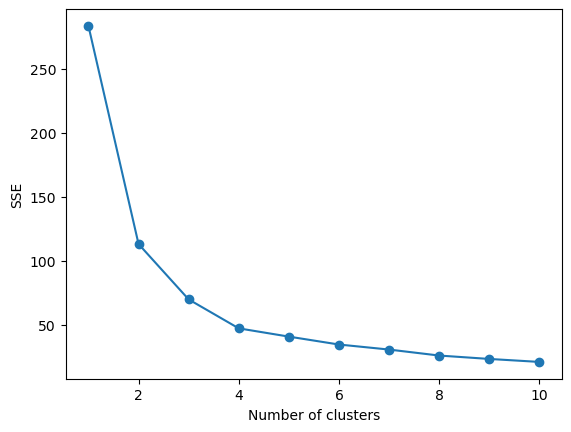

In [87]:
# calculate Sum of Squared Errors (SSE)

sse = []
for i in range(1, 11):
    km2 = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km2.fit(df_sub_cluster)
    sse.append(km2.inertia_)

# plot
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()


In [88]:
# add cluster column to original dataset with countries and non-scaled values
sub_cluster_mpi['sub_clusters'] = y_predicted_sub.tolist()
sub_cluster_mpi

country  child_mort  exports  health  imports  income  inflation  \
0       Albania        16.6     28.0    6.55     48.6    9930       4.49   
1       Algeria        27.3     38.4    4.17     31.4   12900      16.10   
2       Armenia        18.1     20.8    4.40     45.3    6700       7.77   
3    Azerbaijan        39.2     54.3    5.88     20.7   16000      13.80   
4    Bangladesh        49.4     16.0    3.52     21.8    2440       7.14   
..          ...         ...      ...     ...      ...     ...        ...   
74  Timor-Leste        62.6      2.2    9.12     27.8    1850      26.50   
75         Togo        90.3     40.2    7.65     57.3    1210       1.18   
76       Uganda        81.0     17.1    9.01     28.6    1540      10.60   
77        Yemen        56.3     30.0    5.18     34.4    4480      23.60   
78       Zambia        83.1     37.0    5.89     30.9    3280      14.00   

    life_expec  total_fer  gdpp  cluster  mpi_urban  mpi_rural  sub_clusters  
0         76.3       1.65  4090        0      0.003      0.007             0  
1         76.5       2.89  4460        0      0.003      0.011             0  
2         73.3       1.69  3220        0      0.001      0.001             0  
3         69.1       1.92  5840        0      0.009      0.035             0  
4         70.4       2.33   758        0      0.100      0.231             1  
..         ...        ...   ...      ...        ...        ...           ...  
74        71.1       6.23  3600        1      0.176      0.414             1  
75        58.7       4.87   488        1      0.081      0.356             1  
76        56.8       6.15   595        1      0.133      0.408             1  
77        67.5       4.67  1310        1      0.080      0.304             1  
78        52.0       5.40  1460        1      0.130      0.380             1  

[79 rows x 14 columns]

In [89]:
# eliminate the column that contains the country information and cluster as only numeric values should be used in this case for unsupervised learning
sub_cluster_narrow = sub_cluster_mpi.drop(['exports','health','cluster','imports','income','inflation','life_expec','total_fer','mpi_rural'], axis =1)
sub_cluster_narrow.head()

country  child_mort  gdpp  mpi_urban  sub_clusters
0     Albania        16.6  4090      0.003             0
1     Algeria        27.3  4460      0.003             0
2     Armenia        18.1  3220      0.001             0
3  Azerbaijan        39.2  5840      0.009             0
4  Bangladesh        49.4   758      0.100             1

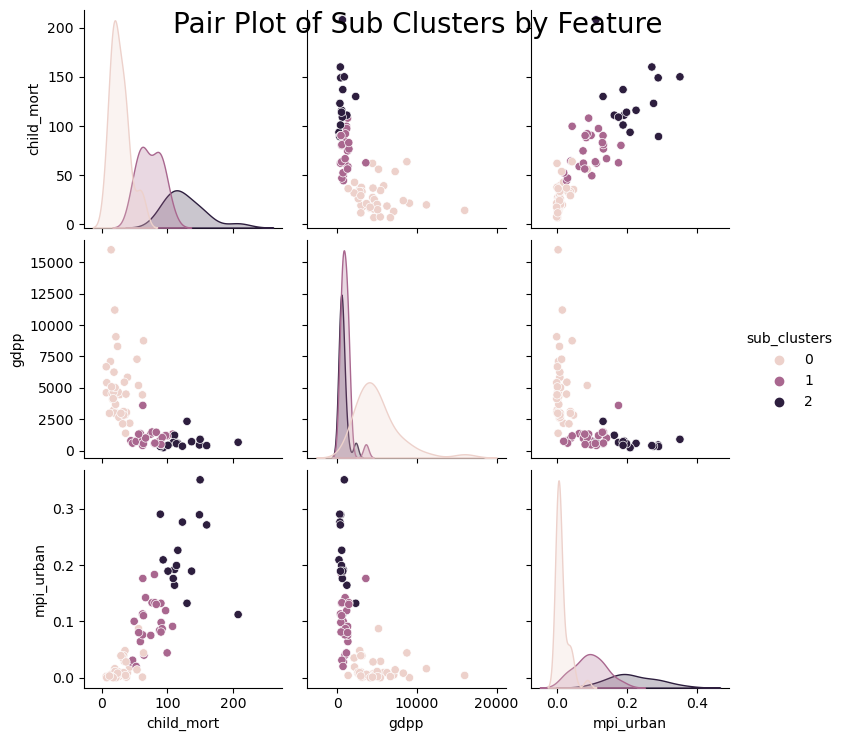

In [90]:
# load example dataset from seaborn 
sns.get_dataset_names()

# plot
sns.pairplot(sub_cluster_narrow, hue="sub_clusters")

# title
plt.suptitle('Pair Plot of Sub Clusters by Feature', 
             size = 20);

In [91]:
# sub_cluster 0 
sub_cluster_0 = sub_cluster_narrow.loc[sub_cluster_narrow['sub_clusters'] == 0]

# list of countries in this country
sub_cluster_0.country.unique()

array(['Albania', 'Algeria', 'Armenia', 'Azerbaijan', 'Barbados',
       'Belize', 'Bhutan', 'Bosnia and Herzegovina', 'Brazil', 'China',
       'Colombia', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Guatemala', 'Guyana', 'Indonesia', 'Jamaica',
       'Jordan', 'Kazakhstan', 'Maldives', 'Mongolia', 'Montenegro',
       'Morocco', 'Peru', 'Philippines', 'Serbia', 'Suriname', 'Thailand',
       'Tunisia', 'Turkmenistan', 'Ukraine', 'Uzbekistan', 'Vanuatu',
       'Gabon', 'Iraq', 'Namibia', 'South Africa'], dtype=object)

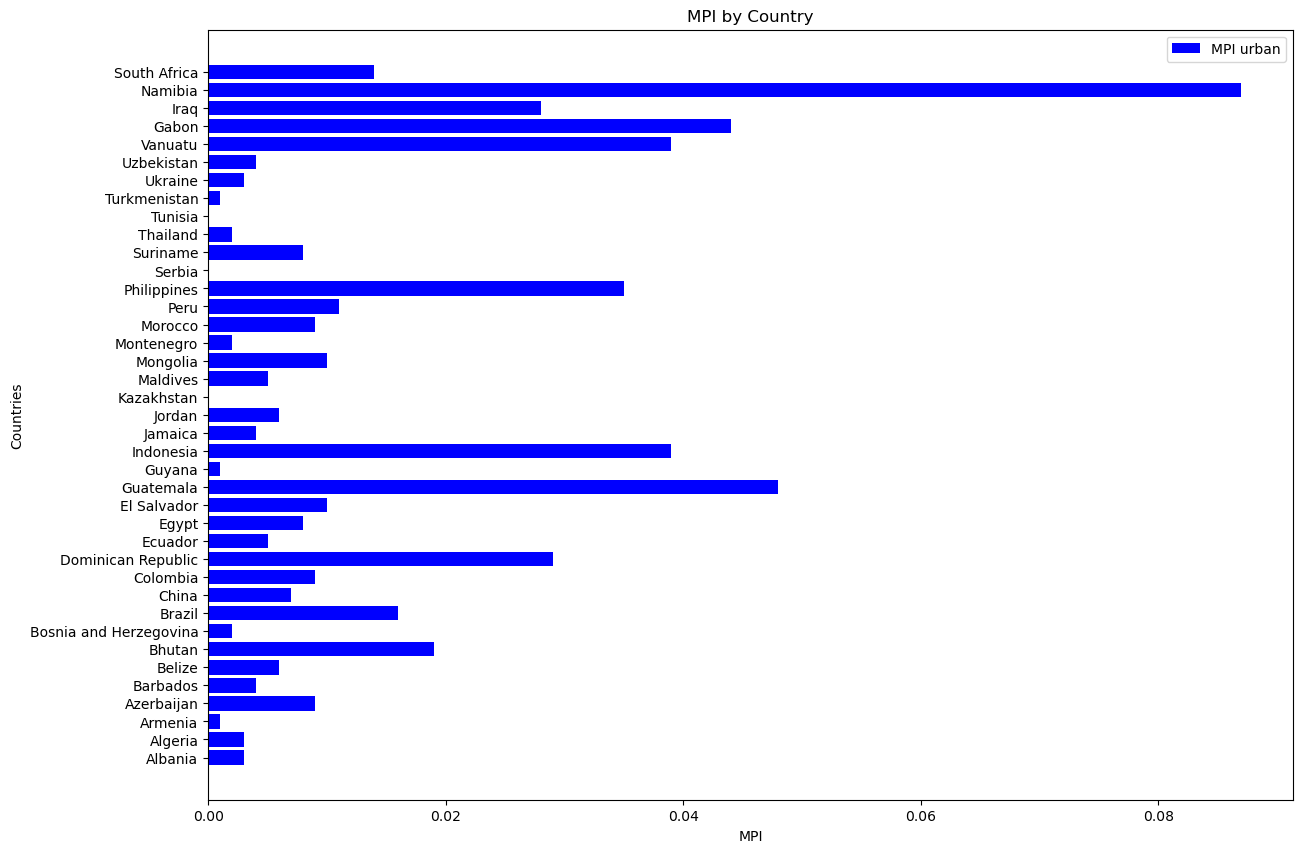

In [92]:
plt.figure(figsize=[14, 10])
plt.barh(sub_cluster_0['country'], sub_cluster_0['mpi_urban'], label = "MPI urban", color = 'b')
plt.legend()
plt.xlabel('MPI')
plt.ylabel('Countries')
plt.title('MPI by Country')
plt.show()

In [93]:
# sub_cluster 1 
sub_cluster_1 = sub_cluster_narrow.loc[sub_cluster_narrow['sub_clusters'] == 1]
# list of countries in this country
sub_cluster_1.country.unique()

array(['Bangladesh', 'Cambodia', 'India', 'Myanmar', 'Nepal',
       'Tajikistan', 'Afghanistan', 'Cameroon', 'Comoros', 'Gambia',
       'Ghana', 'Kenya', 'Lesotho', 'Madagascar', 'Malawi', 'Mauritania',
       'Pakistan', 'Rwanda', 'Senegal', 'Sudan', 'Timor-Leste', 'Togo',
       'Uganda', 'Yemen', 'Zambia'], dtype=object)

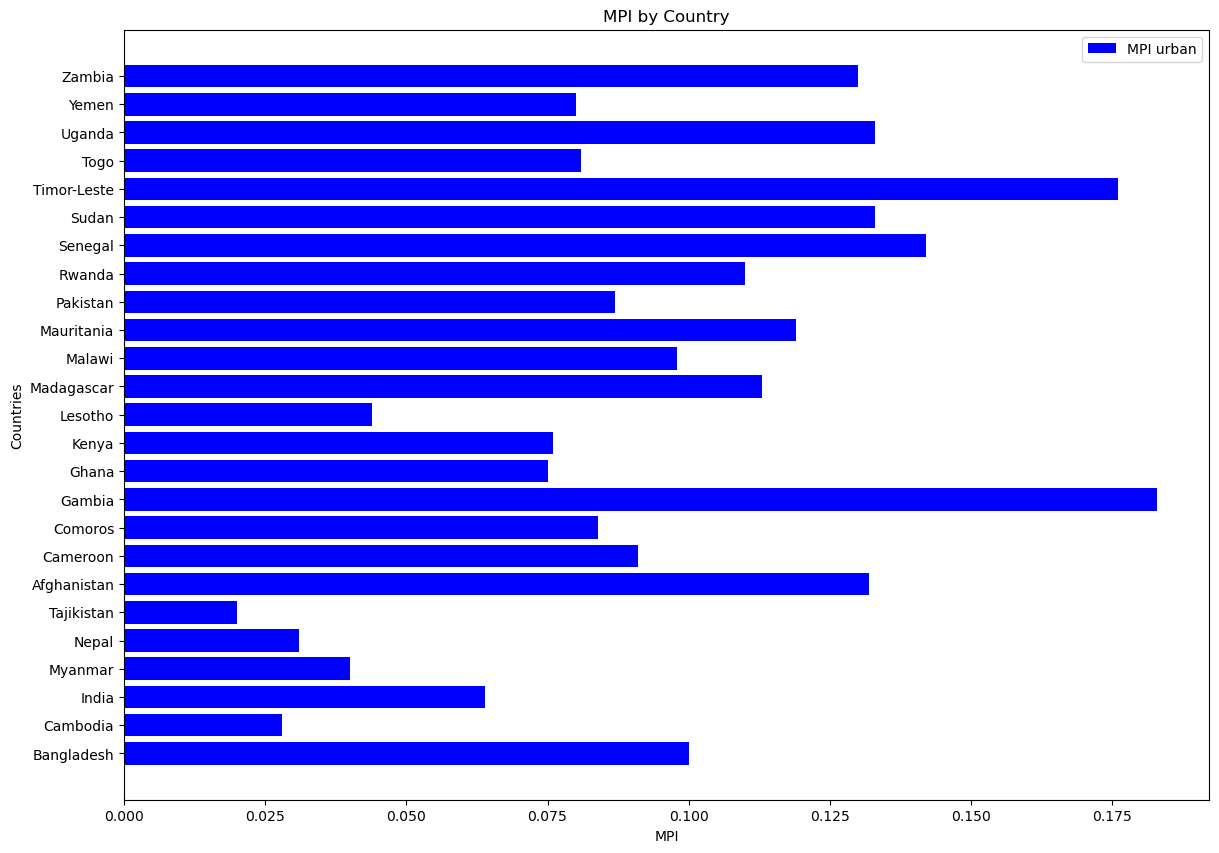

In [94]:
plt.figure(figsize=[14, 10])
plt.barh(sub_cluster_1['country'], sub_cluster_1['mpi_urban'], label = "MPI urban", color = 'b')
plt.legend()
plt.xlabel('MPI')
plt.ylabel('Countries')
plt.title('MPI by Country')
plt.show()

In [95]:
# sub_cluster 2 
sub_cluster_2 = sub_cluster_narrow.loc[sub_cluster_narrow['sub_clusters'] == 2]
# list of countries in this country
sub_cluster_2.country.unique()

array(['Benin', 'Burkina Faso', 'Burundi', 'Central African Republic',
       'Chad', "Cote d'Ivoire", 'Guinea', 'Guinea-Bissau', 'Haiti',
       'Liberia', 'Mali', 'Mozambique', 'Niger', 'Nigeria',
       'Sierra Leone'], dtype=object)

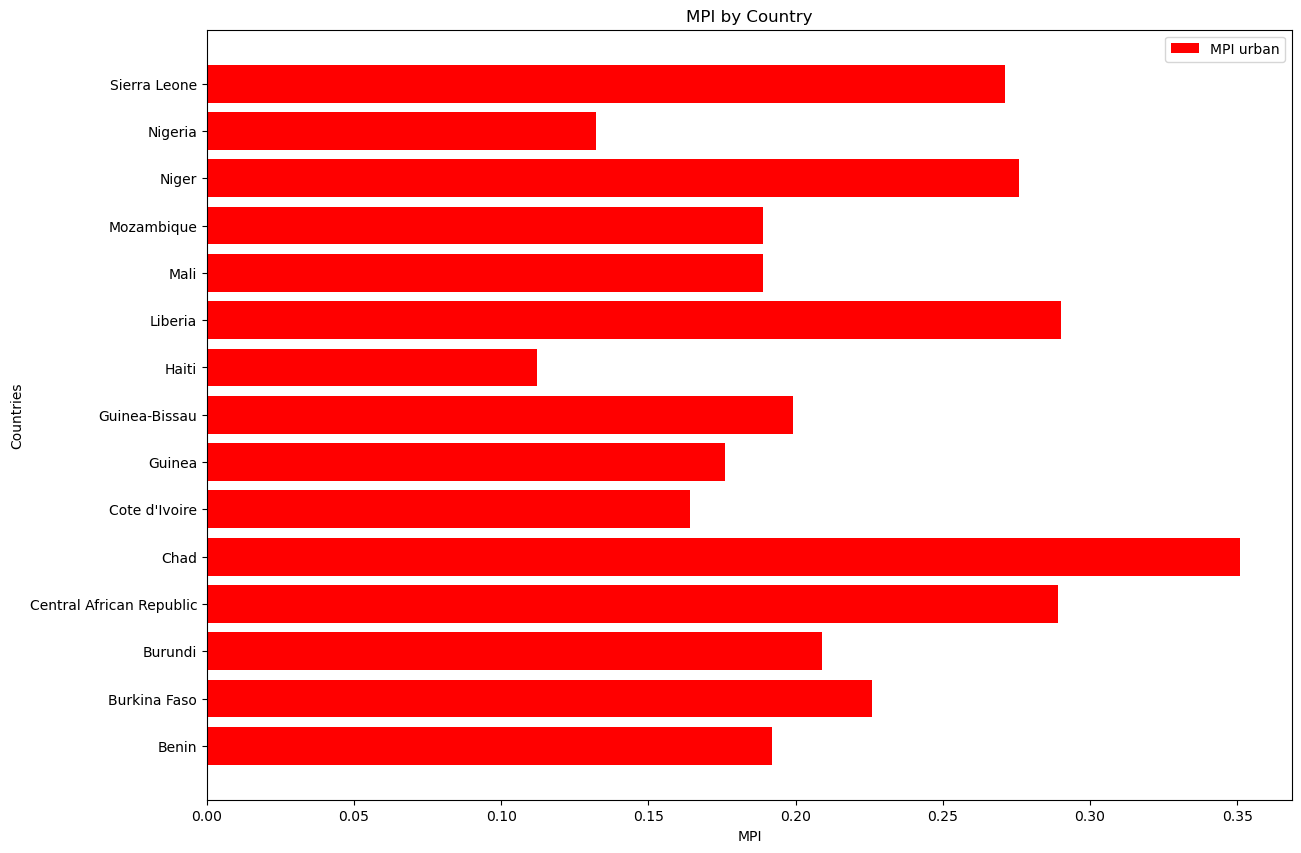

In [96]:
plt.figure(figsize=[14, 10])
plt.barh(sub_cluster_2['country'], sub_cluster_2['mpi_urban'], label = "MPI urban", color = 'r')
plt.legend()
plt.xlabel('MPI')
plt.ylabel('Countries')
plt.title('MPI by Country')
plt.show()

### Results

Recommended countries to allocate funding for development aid:

Countries listed on sub cluster 2, with most critical results based on MPI, child mortality and GDP/person: Benin, Burkina Faso, Burundi, Central African Republic, Chad, Cote d'Ivoire, Gambia, Guinea, Guinea-Bissau,Haiti, Mali, Mozambique, Niger, Nigeria, Sierra Leone.

Countries listed on sub clusters 0 and 1, with critieral results of MPI: Liberia and Tmor-Leste, and child mortality: Cameroon.

### Conclusion

The clustering method alone was not sufficient to provide a final recommendation, however it  contributed to guide actions for further analysis and explore the data in more detail.

Further analysis could be done by adding more features related to the context and constraints that the recommended countries might be facing that could hinder funding value. Issues like corruption, political/civic society crisis/ natural disasters and other risks could expand this. Unsupervised methods like PCA helped in reducing the dimensionalty and K-Means clustring helped in segmenting countries with most critical need of funding.